# Hubble Ultra Deep Field


## Importing packages

In [20]:
import numpy as np 
import sep
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

ModuleNotFoundError: No module named 'sep'

## Read from f105w fits file and display it

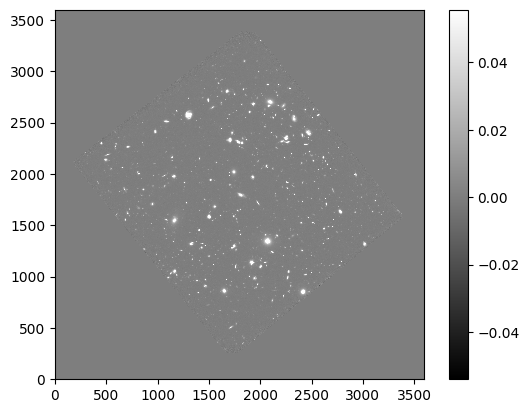

In [21]:
# read image into standard 2-d numpy array
data = fits.open("hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits")[0].data

# show the image
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();

#save the figure as a PNG
plt.savefig("f105w_img_01.PNG", bbox_inches="tight",facecolor="black")

## Background Subtraction

In [22]:
# measure a spatially varying background on the image
#bkg = sep.Background(data) #error with retriving bkg
bkg = sep.Background(data.byteswap().newbyteorder())

# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()

# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

#save the figure as a PNG
plt.savefig("f105w_img_02.PNG", bbox_inches="tight",facecolor="black")

NameError: name 'sep' is not defined

In [ ]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

#save the figure as a PNG
plt.savefig("f105w_img_03.PNG", bbox_inches="tight",facecolor="black")

## Object Detection

In [ ]:
from matplotlib.patches import Ellipse

# subtract the background
data_sub = data - bkg

objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

# how many objects were detected
len(objects)

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
    
#save the figure as a PNG
plt.savefig("f105w_img_04.PNG", bbox_inches="tight",facecolor="black")

In [ ]:
# available fields
objects.dtype.names

In [ ]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

In [ ]:
# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

In [ ]:
#How many sources do you find? Histogram their fluxes.
num_sources = len(objects['x'])
print(f"Sources: {num_sources}")

#plt.figure(figsize=(7, 7))
plt.hist(objects['x'], bins=50) 
plt.xlabel('Flux')
plt.ylabel('Frequency')
plt.title('Histogram of Fluxes')

plt.show()

In [ ]:
#What are the mean, median, and standard deviation of the distribution of fluxes. 
mean_flux = np.mean(flux)
median_flux = np.median(flux)
std_dev_flux = np.std(flux)

print(f"Mean: {mean_flux}")
print(f"Median: {median_flux}")
print(f"Standard Deviation: {std_dev_flux}")

#What is the largest outlier in the distribution, where is it on the image, and how many standard deviations is it away from the mean? 
outliers = [flux for f in flux if np.abs((f - mean_flux) / std_dev_flux) > 3]
largest_outlier = np.max(outliers)

print(f"Largest Outlier: {largest_outlier}")

## Download the f125w and f160w images of the HUDF at the same website, and make a 3-color false image of the UDF using RGB -> f160w, f125w, f105w. Save the image as a PNG.


In [40]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

#define file names 
fdata_F160W = "hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits"
fdata_F125W = "hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits"
fdata_F105W = "hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits"

#read in data 
hdu_2 = fits.open(fdata_F160W)
hdu_3 = fits.open(fdata_F125W)
hdu_4 = fits.open(fdata_F105W)

#get the image data 
data_2 = hdu_2[0].data
data_3 = hdu_3[0].data
data_4 = hdu_4[0].data

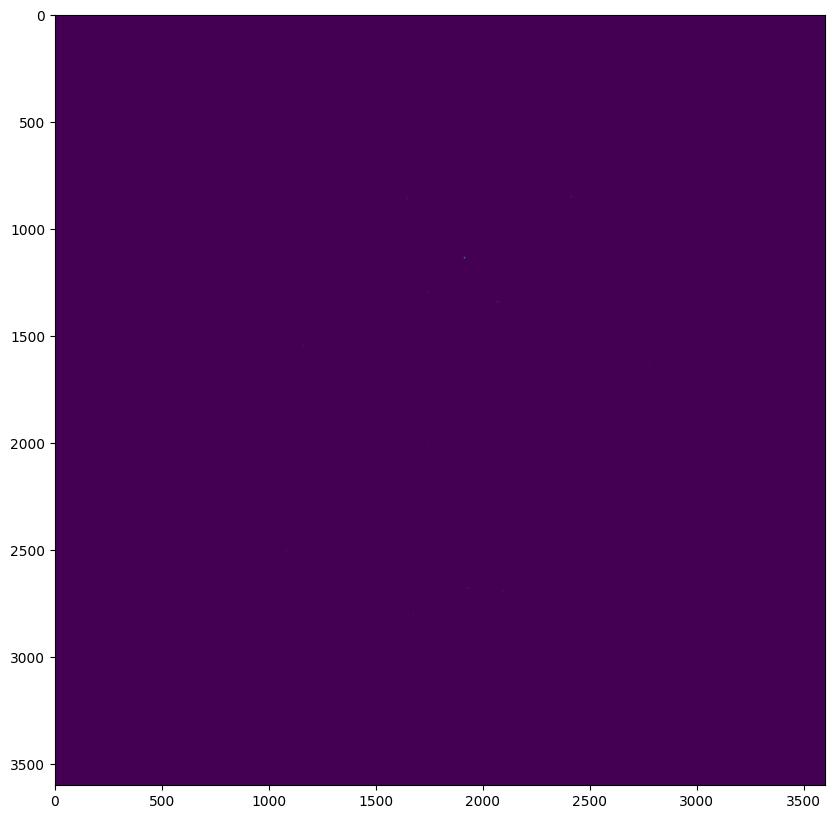

In [35]:
### first do linear scaling 
f = plt.figure(figsize=(10,10))
plt.imshow(data_2)

## Functions for Scaling

In [36]:
def rescale_image(data):
    pdata_tmp = data.copy()
    m = np.nanmean(pdata_tmp)
    vplmin = m/2.
    vpmin = np.log10(vplmin)
    vpmax = np.log10(m * 100.)
    pdata_tmp[pdata_tmp<vplmin] = vplmin
    pdata_tmp = np.log10(pdata_tmp)
    return pdata_tmp, vpmin, vpmax

def fits_quicklook(data, fnx=10, fny=10):
    f = plt.figure(figsize=(fnx, fny))
    pdata_tmp , vpmin, vpmax = rescale_image(data)
    plt.imshow(pdata_tmp, vmin=vpmin,vmax = vpmax )

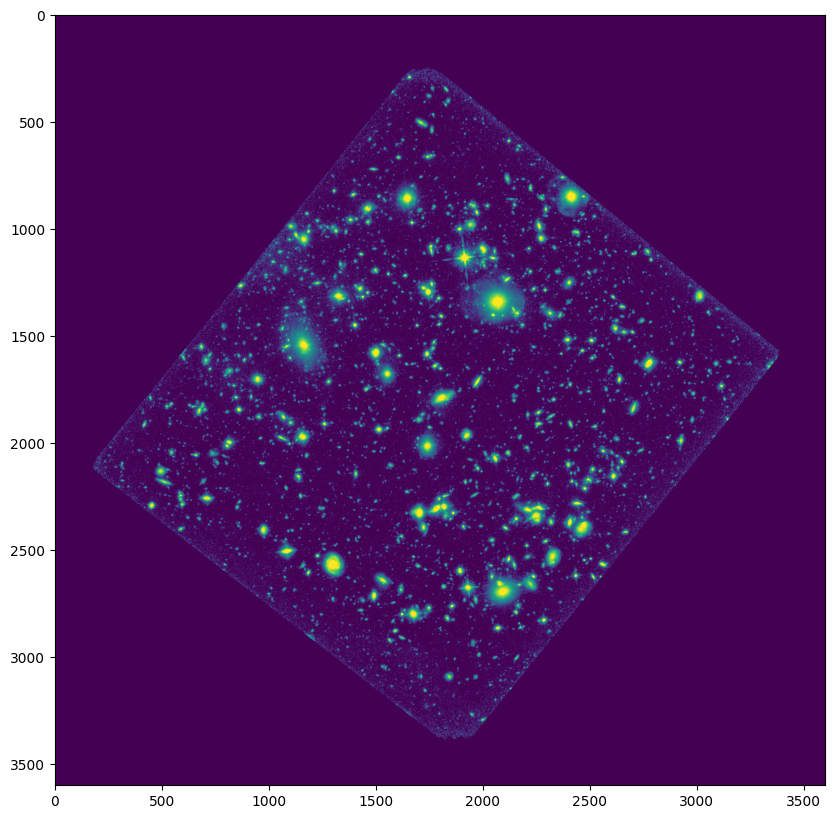

In [37]:
fits_quicklook(data_2)

## using RGB to get the image

In [38]:
### use the rescaled images
data_2_res, d2min, d2max = rescale_image(data_2)
data_3_res, d3min, d3max = rescale_image(data_3)
data_4_res, d4min, d4max = rescale_image(data_4)

data_2_res[data_2_res<d2min] = d2min
data_2_res[data_2_res>d2max] = d2max
data_3_res[data_3_res<d2min] = d3min
data_3_res[data_3_res>d2max] = d3max
data_4_res[data_4_res<d2min] = d4min
data_4_res[data_4_res>d2max] = d4max

rgb = np.zeros((data_2_res.shape[0], data_2_res.shape[1], 3))
rgb [:,:,0] = (data_2_res-d2min)/(d2max-d2min)
rgb [:,:,1] = (data_3_res-d3min)/(d3max-d3min)
rgb [:,:,2] = (data_4_res-d4min)/(d4max-d4min)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


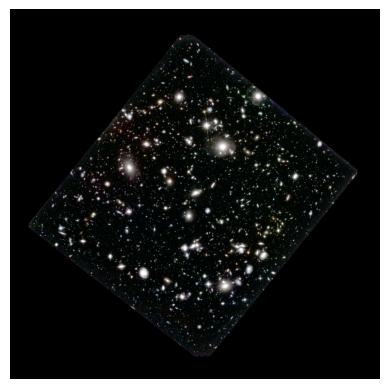

In [39]:
f, ax = plt.subplots(1,1)
ax.axis ('off')
ax.imshow(rgb)
plt.savefig('rgb_final.png', bbox_inches='tight', pad_inches=0, dpi=600)